<a href="https://colab.research.google.com/github/diagonal-hamiltonian/repodynamite/blob/master/SGD-CG-PCG_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import mean_squared_error
np.set_printoptions(precision=3, suppress=True, linewidth=150)

### Supplied code
 An N x N grid has N^2 points, hence the matrix has dimension N^2 x N^2 and the solution vector has dimension N^2
 N is the dimension of the solution grid. It is initially set to N = 4. Increase the value to 40 to 60 when your script is working
 and use this value to obtain results.

 The finite difference equations and boundary condition implementaion require that ths solution grid extend one grid point outside
 the regions where the value of the electrostatic potential is computed. Hence it has dimension (N + 2) x (N + 2).

 A contains the finite difference matrix corresponding to Poisson's equation - del^2 phi = rho / epsilon_0

 f contains the charge density over the solution vector. It is non-zero at only one grid point

 b is the RHS in A . x = b. It contains contributions from f and the boundary conditions.
 
 x is the solution vector. Put your solution from the CG algorithm in x
 soln_grid is an (X, Y) grid containing x in order to enable plotting


In [2]:
N = 40

### Initialising grid

In [ ]:
A = np.zeros(shape=(N*N,N*N))
b = np.zeros(shape=(N*N))
f = np.zeros(shape=(N*N))
x = np.zeros(shape=(N*N))
soln_grid = np.zeros(shape=(N+2,N+2))

f[int(N/2 * N + N/2)] = 22.0

b1=0.0
b2=0.0
b3=0.0
b4=0.0

A[0,0] = 4.0
A[0,1] = -1.0
A[N*N-1,N*N-2] = -1.0
A[N*N-1,N*N-1] = 4.0

In [ ]:
for i in range (1,N*N-1):
    A[i,i] = 4.0
    if (i%N != 0):
        A[i,i-1] = -1.0
    if ((i+1) % N != 0):
        A[i,i+1] = -1.0

for i in range (0,N*N-N):
    A[i,i+N] = -1.0
for i in range (0,N*N-N):
    A[i+N,i] = -1.0

In [ ]:
# Set up boundary conditions and add charge density to b at a single point

for i in range (0,N):
    b[i] = b1
    b[i * N] = b1
    b[i * N + N - 1] = b2
    b[i] = b3
    b[N * (N - 1) + i] = b4

b+=f 

In [ ]:
# Plotting the grid

def plot(x):

  soln_grid = np.zeros(shape=(N+2,N+2))
  for i in range (0,N*N):
    #print(i/N,i%N)
    soln_grid[int(i/N+1),int(i%N+1)] = x[i]
  for i in range (0,N+2):
    soln_grid[i,0]   = b1
    soln_grid[i,N+1] = b2
    soln_grid[0,i]   = b3
    soln_grid[N+1,i] = b4

  fig = plt.figure(figsize=(15,10))
  ax = fig.gca(projection='3d')
  X = np.arange(0,N+2,1)
  Y = np.arange(0,N+2,1)
  X, Y = np.meshgrid(X, Y)

  surf = ax.plot_surface(X, Y, soln_grid)
  plt.show()
#print(soln_grid)

## Algorithms

In [ ]:
def CJ(x ,r, d, b ,num_itts):
 
  for i in range(num_itts):
    alpha = (r.T @ r) / ( d.T @ A @ d) 
    x     = x + alpha * d
    rnew  = r - alpha * (A @ d)
    beta  = rnew.T @ rnew /(r.T @ r)
    r     = rnew
    d     = r + beta * d

  return x, r, d

In [ ]:
def Steepest(x ,num_itts):
  
  for i in range(num_itts):
    r     = b - A@x
    alpha = (r.T @ r) / ( r.T @ A @ r) 
    x     = x + alpha * r
    
  return x, r

In [ ]:
def pre_CJ(x , b , r, zi,  P, Pd ,num_itts):

  for i in range(num_itts):

    ai = (r.T @ zi) / (Pd.T @ A @ Pd)
    x  = x + ai*Pd
    rnew = r - ai * A @ Pd
    znew = P @ P.T @ rnew
    B = (rnew.T @ znew) / (r.T @ zi)
    Pd = znew + B * Pd
    zi = znew
    r  = rnew 
  return x, r, zi, Pd

## Evaluation and plotting

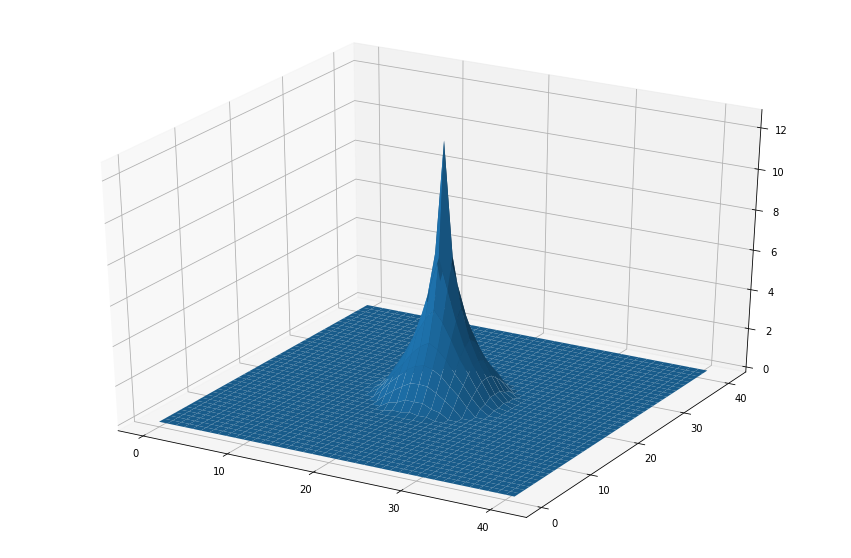

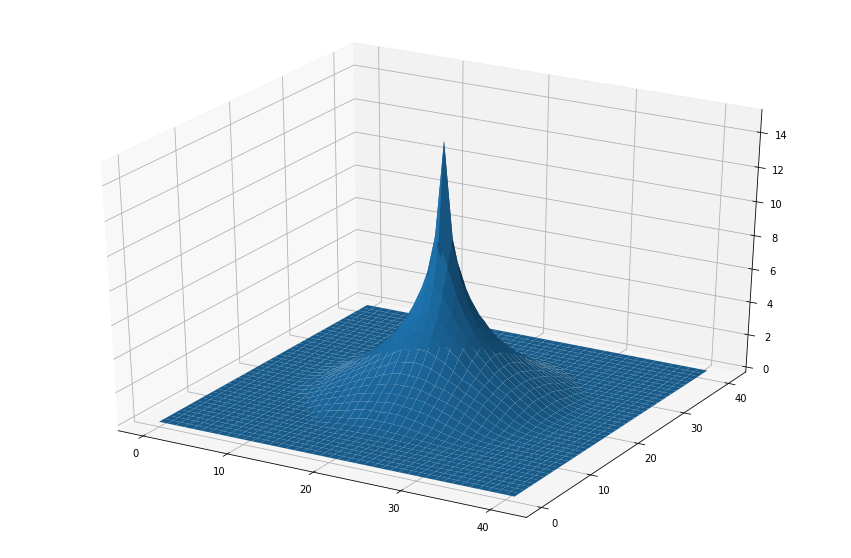

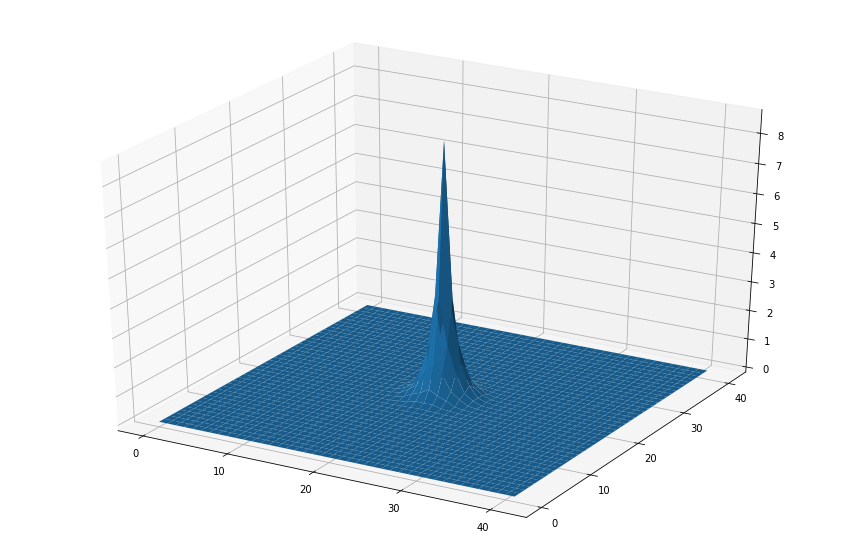

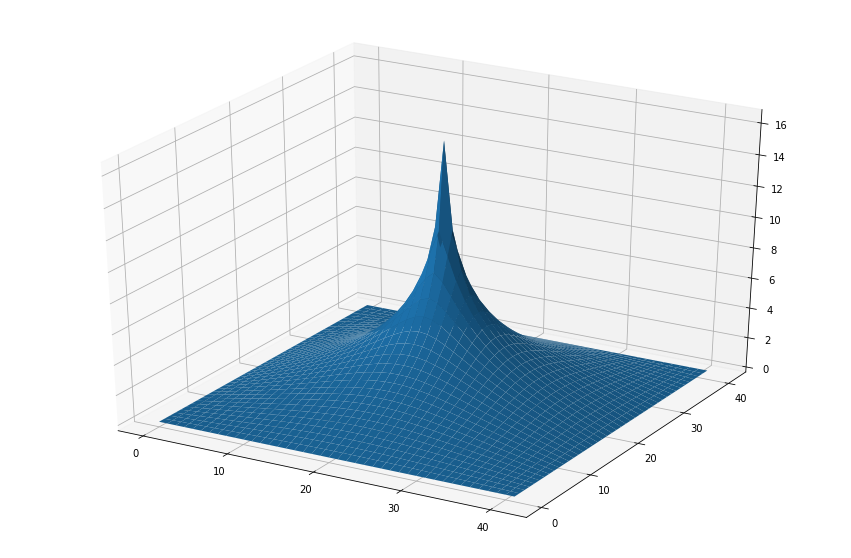

In [ ]:

# CJ Method
dd = rr = b
con_CJ = CJ(x, rr, dd,  b, 10)[0]
plot(con_CJ)

#PCJ Method

D      = np.zeros_like(A)  # Diag of A
D_half = np.zeros_like(A)  # Diag of A^(-1/2)
for i in range(N*N): D[i,i] = A[i,i]; D_half[i,i] = D[i,i]**(-0.5);
L = np.tril(A, k = -1)     # Lower triang of A
P = ( D - 1.7*L ) @ D_half

conv_PC = pre_CJ(num_itts = 10,
                   x = x, 
                   b = b,
                   r = b,
                   zi= P@P.T@b,
                   P = P,
                   Pd = P@P.T@b)[0]

plot(conv_PC)


# Steepest Descent

con_SD = Steepest(x,10)[0]
plot(con_SD)


# Analytical solution x = A b

x_Anal = scipy.linalg.solve( A ,b )
plot(x_Anal)

## Convergence over a range of omega for C

In [ ]:
threshold    = 1e-18

In [ ]:
# Initialising 
omega        = np.linspace(0., 2, 100) # Range of omega
P            = np.array( [( D - om*L ) @ D_half for om in omega] ) 
con_itts_PC  = np.zeros_like(omega)

In [ ]:
# Itterating over a range of omegea for the PCJ method

for i,om in enumerate(omega):

  pre_Pd = P[i]@P[i].T@b
  pre_zi = P[i]@P[i].T@b
  pre_r = b
  pre_x = x 
  num_itt_PC = 0;   err_PC = 100;

  while( err_PC > threshold ):
    num_itt_PC+=1

    cur_x, cur_r, cur_zi, cur_Pd = pre_CJ(x = pre_x, 
                                          Pd= pre_Pd,
                                          r = pre_r,
                                          zi= pre_zi,
                                          b = b,
                                          P = P[i],
                                          num_itts = 1)
    
    err_PC = cur_r.T @ cur_r
    pre_x, pre_r, pre_zi, pre_Pd = cur_x, cur_r, cur_zi, cur_Pd
  con_itts_PC[i]  = num_itt_PC

In [ ]:
# Itterating until convergence CJ

pre_x, pre_r, pre_d = x, b, b
err_CJ = 10
num_itt_CJ = 0

while( err_CJ > threshold ):
  num_itt_CJ+=1

  cur_x, cur_r, cur_d = CJ(pre_x, pre_r, pre_d,  b, 1)
  err_CJ = cur_r.T @ cur_r
  pre_x, pre_r, pre_d = cur_x, cur_r, cur_d

print(num_itt_CJ)

129


In [ ]:
# Itterating until convergence SD

pre_x      = x
err_SD     = 10
num_itt_SD = 0

while( err_SD > threshold ):
  num_itt_SD+=1

  cur_x, cur_r  = Steepest(pre_x, 1)
  err_SD = cur_r.T @ cur_r
  pre_x = cur_x

print(num_itt_SD)

6020


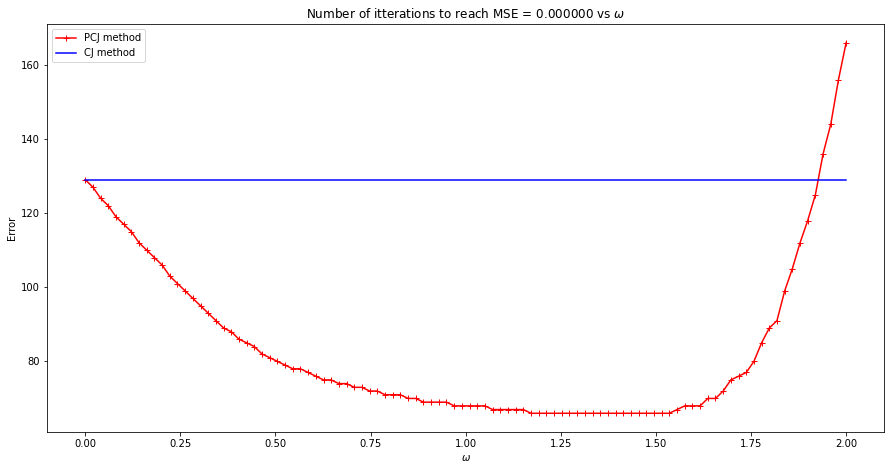

In [ ]:
plt.figure( figsize=(15,7.5) )
plt.title( 'Number of itterations to reach MSE = %f vs $\omega$'%(threshold) )
plt.plot( omega, con_itts_PC, 'r+-', label = 'PCJ method')
plt.plot( omega, np.array(len(omega) * [num_itt_CJ]), 'b', label = 'CJ method')
plt.xlabel('$\omega$')
plt.ylabel('Itterations until convergence')
plt.legend()
plt.show()

## Convergence over a number of itterations using a threshold $\omega = 1.4$
$$
treshold = r_i^Tr_i
$$

In [ ]:
threshold    = 1e-15

# Itterating until convergence CJ

pre_x, pre_r, pre_d = x, b, b
err_CJ      = 10
num_itt_CJ  = 0
err_CJ_list = []

while( err_CJ > threshold ):
  num_itt_CJ+=1

  cur_x, cur_r, cur_d = CJ(pre_x, pre_r, pre_d,  b, 1)
  err_CJ = cur_r.T @ cur_r
  err_CJ_list.append(err_CJ)
  pre_x, pre_r, pre_d = cur_x, cur_r, cur_d

err_CJ_list.append(err_CJ)

In [ ]:
# Itterating until convergence PC

P = ( D - 1.4 * L ) @ D_half
pre_Pd = P@P.T@b
pre_zi = P@P.T@b
pre_r = b
pre_x = x 
num_itt_PC = 0;   err_PC = 100;
err_PC_list = []

while( err_PC > threshold ):
  num_itt_PC+=1

  cur_x, cur_r, cur_zi, cur_Pd = pre_CJ(x = pre_x, 
                                        Pd= pre_Pd,
                                        r = pre_r,
                                        zi= pre_zi,
                                        b = b,
                                        P = P,
                                        num_itts = 1)
  
  err_PC = cur_r.T @ cur_r
  err_PC_list.append(err_PC)
  pre_x, pre_r, pre_zi, pre_Pd = cur_x, cur_r, cur_zi, cur_Pd

err_PC_list.append(err_PC)

In [ ]:
# Itterating until convergence SD

pre_x      = x
err_SD     = 10
num_itt_SD = 0
err_SD_list= []

while( err_SD > threshold ):
  num_itt_SD+=1

  cur_x, cur_r  = Steepest(pre_x, 1)
  err_SD = cur_r.T @ cur_r
  err_SD_list.append(err_SD)

  pre_x = cur_x

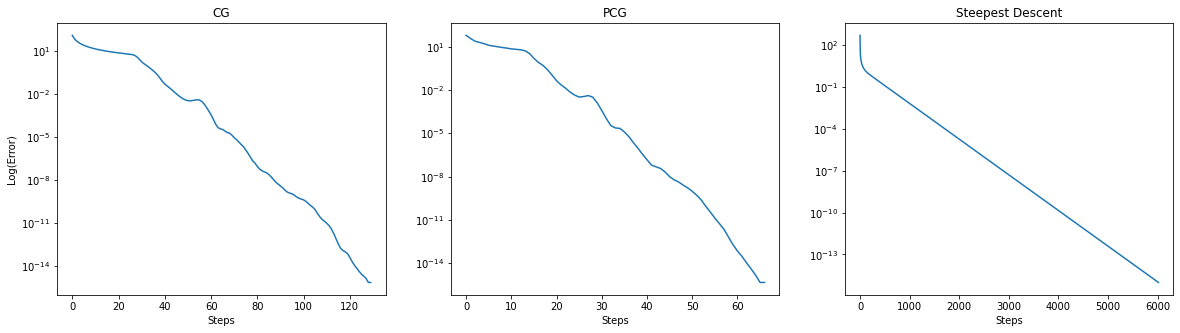

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(range(len(err_CJ_list)),err_CJ_list, )
plt.yscale('log')
plt.ylabel('Log(Error)')
plt.xlabel('Steps')
plt.title('CG')
plt.subplot(132)
plt.plot(range(len(err_PC_list)),err_PC_list, )
plt.yscale('log')
plt.title('PCG')
plt.xlabel('Steps')

plt.subplot(133)
plt.plot(range(len(err_SD_list)),err_SD_list, )
plt.title('Steepest Descent')
plt.yscale('log')
plt.xlabel('Steps')
plt.show()


## Condition Number

In [ ]:
AA        = np.zeros_like( P )
cond_nums = np.zeros( len(P) )
min_eigs  = np.zeros( len(P) )

for i in range( len(P) ):
  AA           =  P[i].T @ A @ P[i]
  cond_nums[i] =  np.linalg.cond(AA) 
  min_eigs[i]  =  np.min( np.linalg.eigvals(AA) )

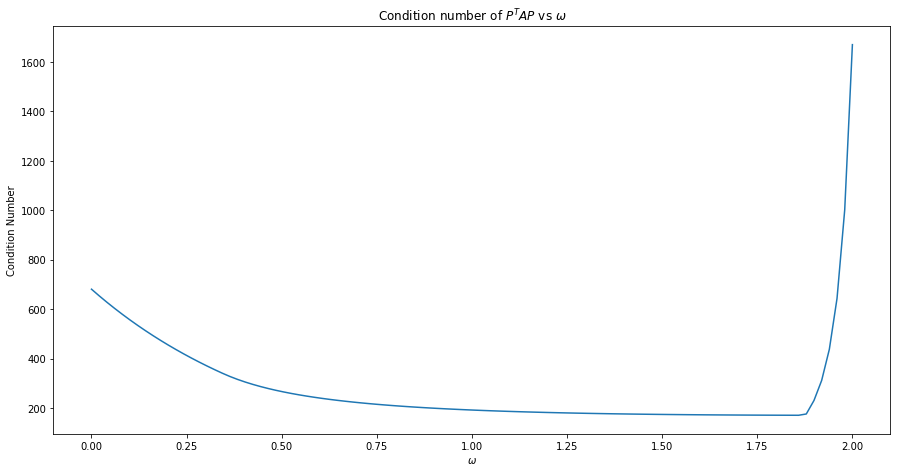

min condition number omega value =  1.8585858585858588
min condition number =  170.31466374856853


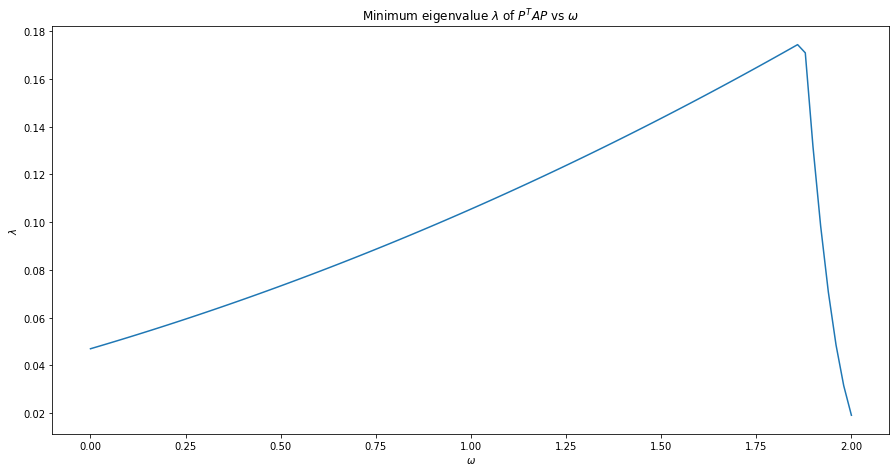

Max eig. omega value =  1.8585858585858588
Min Eig. Val =  0.019076163900672898


In [ ]:
# Plotting

plt.figure( figsize=(15,7.5) )
plt.title( 'Condition number of $P^TAP$ vs $\omega$' )
plt.plot( omega, cond_nums)
plt.xlabel('$\omega$')
plt.ylabel('Condition Number')
plt.show()
print('min condition number omega value = ', omega[np.argmin(cond_nums)])
print('min condition number = ', np.min(cond_nums))

plt.figure( figsize=(15,7.5) )
plt.title( 'Minimum eigenvalue $\lambda$ of $P^TAP$ vs $\omega$' )
plt.plot( omega, min_eigs)
plt.xlabel('$\omega$')
plt.ylabel('$\lambda$')
plt.show()
print('Max eig. omega value = ', omega[np.argmax(min_eigs)])
print('Min Eig. Val = ', np.min(min_eigs))

The condition number associated with the linear equation Ax = b gives a bound on how inaccurate the solution x will be after approximation. If A is symmetric, the condition number is


$$
k = \frac{\lambda_{max}}{\lambda_{min}}.
$$

and it bounds the relative error of x as

$$
\|\delta \mathbf{x}\| /\|\mathbf{x}\| \leq\|\delta \mathbf{b}\| /\|\mathbf{b}\| k.
$$

In the case that A is not symmetric,
$$
c = |A||A^{-1}| 
$$

$$
\|\delta \mathbf{x}\| /\|\mathbf{x}\| \leq\|\delta \mathbf{b}\| /\|\mathbf{b}\| c.
$$

$$
\|\delta \mathbf{x}\| /\|\mathbf{x}\| \leq\|\delta \mathbf{A}\| /\|\mathbf{A}\| c.
$$

In our case $A\rightarrow P^TAP$. This means the first case applies.


So in the first graph of the condition number vs omega we see the graph slowly decline asymptotically toward k=200. After $\omega = 1.86$ the condition number increases rapidly. This means that after the 1.86 the error rapidly begins to become unbounded.

In the second graph at 1.86 The largest contribution to $\delta x $ will come from eigenvectors with the smallest eigenvalues and those for which $\delta b $ and xi are nearly parallel. This means that as $\omega$ goes past 1.86, the matrix $P^TAP$ becomes nearly singular. At 1.86 the eigenvalue is at a maximum so it will be the least sensitive to errrors in the range of omega.